In [1]:
cd scripts/

/home/ubuntu/facebook/scripts


In [2]:
import numpy as np
#Import libraries:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

from sklearn.cross_validation import train_test_split
import pickle

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

In [3]:
def transform_x(X, x_transformer = None):
    """
    X = [[x, y, a, t]]
    """
    fw = [500., 1000., 4., 3., 2., 10., 10.]
    minute_v = X[:, 3]%60
    hour_v = X[:, 3]//60
    weekday_v = hour_v//24
    month_v = weekday_v//30
    year_v = (weekday_v//365 + 1)*fw[5]
    hour_v = ((hour_v%24 + 1) + minute_v/60.0)*fw[2]
    hour_v_2 = (X[:, 3]%(60*60*24))//(60*60*2)
    hour_v_3 = (X[:, 3]%(60*60*24))//(60*60*3)
    hour_v_4 = (X[:, 3]%(60*60*24))//(60*60*4)
    hour_v_6 = (X[:, 3]%(60*60*24))//(60*60*6)
    hour_v_8 = (X[:, 3]%(60*60*24))//(60*60*8)
    weekday_v = (weekday_v%7 + 1)*fw[3]
    month_v = (month_v%12 +1)*fw[4]
    accuracy_v = np.log10(X[:, 2])*fw[6]
    x_v = X[:, 0]*fw[0]
    y_v = X[:, 1]*fw[1]
    return np.hstack((x_v.reshape(-1, 1),
                     y_v.reshape(-1, 1),
                     accuracy_v.reshape(-1, 1),
                     hour_v.reshape(-1, 1),
                     hour_v_2.reshape(-1, 1),
                     hour_v_3.reshape(-1, 1),
                     hour_v_4.reshape(-1, 1),
                     hour_v_6.reshape(-1, 1),
                     hour_v_8.reshape(-1, 1),
                     weekday_v.reshape(-1, 1),
                     month_v.reshape(-1, 1),
                     year_v.reshape(-1, 1)))

def transform_y(y, y_transformer = None):
    """
    place_ids to encoded array
    """
    y = y.astype(int)
    if y_transformer == None:
        label_encoder = LabelEncoder()
        label_encoder.fit(y)
        y_transformer = {'encoder': label_encoder}
    new_y = y_transformer['encoder'].transform(y).reshape(-1, 1)
    return (new_y, y_transformer)

def map3eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,4)]
    metric = 0.
    for i in range(3):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@3', metric

def load_data(m, n):
    return np.loadtxt('../grid1_400_100_50_10/grid_data_' + str(m)  + '_' + str(n) + '.csv', delimiter = ',')

def get_preds(probs, encoder):
    return encoder.inverse_transform(np.argsort(probs, axis = 1)[:, ::-1][:, :3])


In [4]:
m, n = 12, 40
data = load_data(m, n)

M = pickle.load(open('../grid1_400_100_50_10/cardinality_pickle.pkl', 'rb'))

train, test = train_test_split(data, test_size = 0.02)

In [5]:
mask = np.array(map(lambda x: M[m][n][x] > 20, train[:, 5]))
card_train = train[mask, :]
print card_train.shape, "card_train_shape"
print train.shape, "train_shape"
print test.shape, "test_shape"



(14356, 6) card_train_shape
(16178, 6) train_shape
(331, 6) test_shape


In [6]:
X = transform_x(card_train[:, (1, 2, 3, 4)])
y_orig, enc = transform_y(data[:, 5])
y, enc = transform_y(card_train[:, 5], enc)
test_X = transform_x(test[:, (1, 2, 3, 4)])
test_y, enc = transform_y(test[:, 5], enc)
print X.shape, "X shape"
print y.shape, "y shape"
print test_X.shape, "test_X shape"
print test_y.shape, "test_y shape"
print len(enc['encoder'].classes_)

dtrain = xgb.DMatrix(X, label=np.ravel(y))
dtest = xgb.DMatrix(test_X, label=np.ravel(test_y))

(14356, 12) X shape
(14356, 1) y shape
(331, 12) test_X shape
(331, 1) test_y shape
770


[0]	train-MAP@3:0.458589	test-MAP@3:0.380665
[1]	train-MAP@3:0.519279	test-MAP@3:0.429003
[2]	train-MAP@3:0.554357	test-MAP@3:0.459215
[3]	train-MAP@3:0.580248	test-MAP@3:0.477341
[4]	train-MAP@3:0.601267	test-MAP@3:0.495468
[5]	train-MAP@3:0.623469	test-MAP@3:0.510574
[6]	train-MAP@3:0.640799	test-MAP@3:0.528701
[7]	train-MAP@3:0.661609	test-MAP@3:0.537764
[8]	train-MAP@3:0.678174	test-MAP@3:0.55287
[9]	train-MAP@3:0.692163	test-MAP@3:0.567976
[10]	train-MAP@3:0.706083	test-MAP@3:0.574018
[11]	train-MAP@3:0.717984	test-MAP@3:0.583082
[12]	train-MAP@3:0.730373	test-MAP@3:0.583082
[13]	train-MAP@3:0.742135	test-MAP@3:0.586103
[14]	train-MAP@3:0.752714	test-MAP@3:0.595166
[15]	train-MAP@3:0.761832	test-MAP@3:0.601208
[16]	train-MAP@3:0.770601	test-MAP@3:0.601208
[17]	train-MAP@3:0.777492	test-MAP@3:0.610272
[18]	train-MAP@3:0.784452	test-MAP@3:0.616314
[19]	train-MAP@3:0.792247	test-MAP@3:0.622356
[20]	train-MAP@3:0.798093	test-MAP@3:0.625378
[21]	train-MAP@3:0.805679	test-MAP@3:0.628399

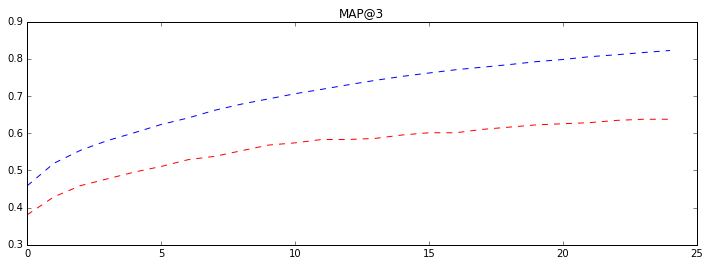

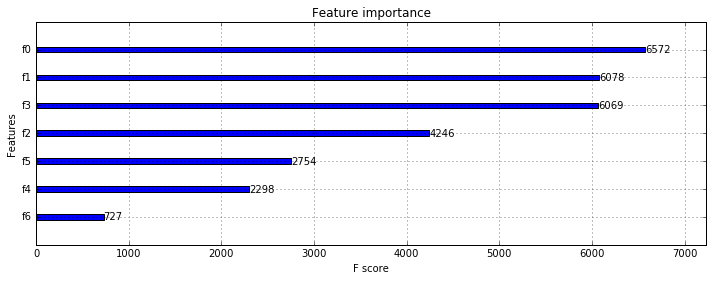

In [176]:
"""
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 nthread=4,
 scale_pos_weight=1
"""
# lower learning rate and more iterations
er4 = {}
bst4 = xgb.train({'num_class': len(enc['encoder'].classes_),
                 'silent': 0,
                 'nthread': 4,
                 'eta': 0.1,
                 'objective': 'multi:softprob',
                 'max_depth': 5,
                 'min_child_weight': 1,
                 'gamma': 0,
                 'subsample': 0.8,
                 'colsample_bytree': 0.8,
                 'scale_pos_weight': 1}, 
                dtrain, 
                num_boost_round = 25,
                evals = [(dtrain, 'train'), (dtest, 'test')],
                verbose_eval = True, evals_result = er4,
                feval = map3eval)

plt.figure()
plt.plot(er4['test']['MAP@3'], 'r--', er4['train']['MAP@3'], 'b--')
plt.title("MAP@3")
xgb.plot_importance(bst4)

[0]	train-MAP@3:0.508352	test-MAP@3:0.429003
[1]	train-MAP@3:0.561038	test-MAP@3:0.483384
[2]	train-MAP@3:0.599109	test-MAP@3:0.513595
[3]	train-MAP@3:0.62855	test-MAP@3:0.531722
[4]	train-MAP@3:0.650125	test-MAP@3:0.540785
[5]	train-MAP@3:0.667873	test-MAP@3:0.561934
[6]	train-MAP@3:0.681723	test-MAP@3:0.567976
[7]	train-MAP@3:0.694738	test-MAP@3:0.577039
[8]	train-MAP@3:0.709354	test-MAP@3:0.586103
[9]	train-MAP@3:0.721395	test-MAP@3:0.595166
[10]	train-MAP@3:0.733853	test-MAP@3:0.598187
[11]	train-MAP@3:0.744919	test-MAP@3:0.60423
[12]	train-MAP@3:0.754037	test-MAP@3:0.610272
[13]	train-MAP@3:0.763363	test-MAP@3:0.610272
[14]	train-MAP@3:0.772272	test-MAP@3:0.616314
[15]	train-MAP@3:0.780206	test-MAP@3:0.619335
[16]	train-MAP@3:0.787514	test-MAP@3:0.622356
[17]	train-MAP@3:0.794404	test-MAP@3:0.622356
[18]	train-MAP@3:0.80039	test-MAP@3:0.625378
[19]	train-MAP@3:0.806723	test-MAP@3:0.625378
[20]	train-MAP@3:0.813057	test-MAP@3:0.63142
[21]	train-MAP@3:0.818555	test-MAP@3:0.634441
[2

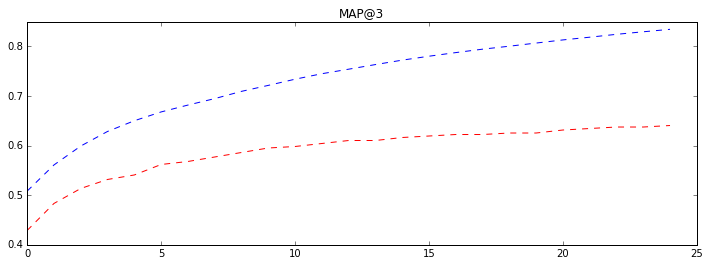

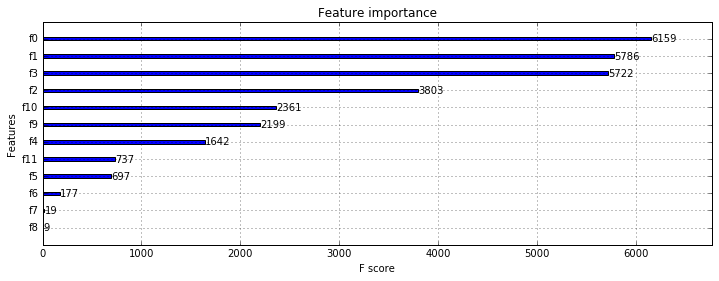

In [182]:
"""
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 nthread=4,
 scale_pos_weight=1
"""
# lower learning rate and more iterations
er4 = {}
bst4 = xgb.train({'num_class': len(enc['encoder'].classes_),
                 'silent': 0,
                 'nthread': 4,
                 'eta': 0.1,
                 'objective': 'multi:softprob',
                 'max_depth': 5,
                 'min_child_weight': 1,
                 'gamma': 0,
                 'subsample': 0.8,
                 'colsample_bytree': 0.8,
                 'scale_pos_weight': 1}, 
                dtrain, 
                num_boost_round = 25,
                evals = [(dtrain, 'train'), (dtest, 'test')],
                verbose_eval = True, evals_result = er4,
                feval = map3eval)

plt.figure()
plt.plot(er4['test']['MAP@3'], 'r--', er4['train']['MAP@3'], 'b--')
plt.title("MAP@3")
xgb.plot_importance(bst4)

[0]	train-MAP@3:0.284521	test-MAP@3:0.238671
[1]	train-MAP@3:0.357948	test-MAP@3:0.308157
[2]	train-MAP@3:0.419335	test-MAP@3:0.353474
[3]	train-MAP@3:0.472856	test-MAP@3:0.404834
[4]	train-MAP@3:0.516565	test-MAP@3:0.435045
[5]	train-MAP@3:0.568694	test-MAP@3:0.477341
[6]	train-MAP@3:0.606765	test-MAP@3:0.507553
[7]	train-MAP@3:0.641773	test-MAP@3:0.534743
[8]	train-MAP@3:0.667803	test-MAP@3:0.55287
[9]	train-MAP@3:0.688822	test-MAP@3:0.561934
[10]	train-MAP@3:0.70664	test-MAP@3:0.574018
[11]	train-MAP@3:0.721186	test-MAP@3:0.583082
[12]	train-MAP@3:0.734271	test-MAP@3:0.598187
[13]	train-MAP@3:0.748399	test-MAP@3:0.610272
[14]	train-MAP@3:0.758839	test-MAP@3:0.613293
[15]	train-MAP@3:0.767748	test-MAP@3:0.619335
[16]	train-MAP@3:0.775056	test-MAP@3:0.628399
[17]	train-MAP@3:0.782642	test-MAP@3:0.63142
[18]	train-MAP@3:0.790159	test-MAP@3:0.63142
[19]	train-MAP@3:0.796701	test-MAP@3:0.63142
[20]	train-MAP@3:0.802199	test-MAP@3:0.637462
[21]	train-MAP@3:0.808742	test-MAP@3:0.643505
[22

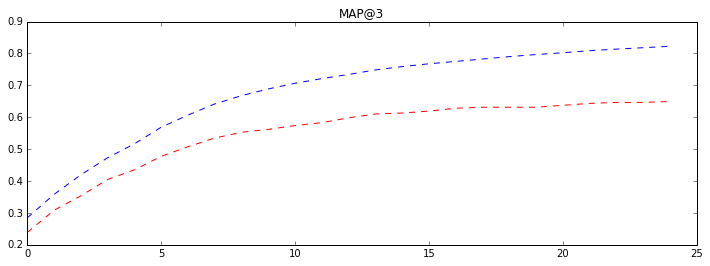

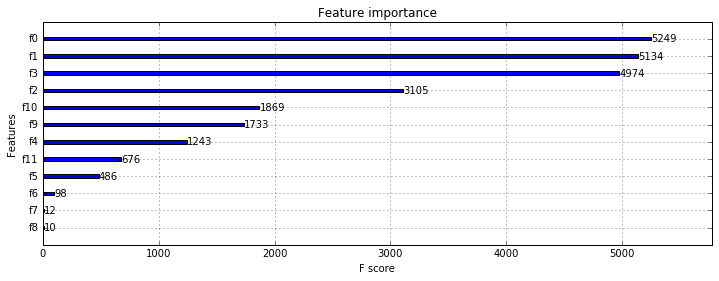

In [183]:
"""
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 nthread=4,
 scale_pos_weight=1
"""
# lower learning rate and more iterations
er4 = {}
bst4 = xgb.train({'num_class': len(enc['encoder'].classes_),
                 'silent': 0,
                 'nthread': 4,
                 'eta': 0.1,
                 'objective': 'multi:softprob',
                 'max_depth': 9,
                 'min_child_weight': 5,
                 'gamma': 0,
                 'subsample': 0.8,
                 'colsample_bytree': 0.8,
                 'scale_pos_weight': 1}, 
                dtrain, 
                num_boost_round = 25,
                evals = [(dtrain, 'train'), (dtest, 'test')],
                verbose_eval = True, evals_result = er4,
                feval = map3eval)

plt.figure()
plt.plot(er4['test']['MAP@3'], 'r--', er4['train']['MAP@3'], 'b--')
plt.title("MAP@3")
xgb.plot_importance(bst4)

In [122]:
X[:3]

array([[  2.51130000e+03,   4.80280000e+03,   1.82607480e+01,
          9.25333333e+01,   3.00000000e+00,   1.00000000e+01,
          1.00000000e+01],
       [  2.50415000e+03,   4.70320000e+03,   2.57287160e+01,
          7.64666667e+01,   9.00000000e+00,   6.00000000e+00,
          2.00000000e+01],
       [  2.59260000e+03,   4.79980000e+03,   1.76342799e+01,
          4.13333333e+00,   9.00000000e+00,   2.00000000e+00,
          2.00000000e+01]])

In [110]:
er = {}
bst = xgb.train({
                 'silent': 0,
                 'eval_metric': ['map@3'],
                 'eta': 0.1,
                 'objective': 'rank:pairwise',
                 }, 
                dtrain, 
                num_boost_round = 25,
                verbose_eval = True, evals = [(dtrain, 'train')], evals_result = er)

[0]	train-map@3:0.120556
[1]	train-map@3:0.120556
[2]	train-map@3:0.120556
[3]	train-map@3:0.120556
[4]	train-map@3:0.120556
[5]	train-map@3:0.120556
[6]	train-map@3:0.120556
[7]	train-map@3:0.120556
[8]	train-map@3:0.120556
[9]	train-map@3:0.120556
[10]	train-map@3:0.120556
[11]	train-map@3:0.120556
[12]	train-map@3:0.120556
[13]	train-map@3:0.120556
[14]	train-map@3:0.120556
[15]	train-map@3:0.120556
[16]	train-map@3:0.120556
[17]	train-map@3:0.120556
[18]	train-map@3:0.120556
[19]	train-map@3:0.120556
[20]	train-map@3:0.120556
[21]	train-map@3:0.120556
[22]	train-map@3:0.120556
[23]	train-map@3:0.120556
[24]	train-map@3:0.120556


In [8]:
best_map = 0
best_max_depth = 0
best_min_child_weight = 0
results3 = []
for max_depth in range(9, 20, 2):
    for min_child_weight in range(5, 16, 2):
        print "max_depth is %s" %(max_depth)
        print "min_child_weight is %s" %(min_child_weight)
        temp_cv = xgb.cv({'num_class': len(enc['encoder'].classes_),
                 'silent': 0,
                 'nthread': 8,
                 'eta': 0.1,
                 'objective': 'multi:softprob',
                 'max_depth': max_depth,
                 'min_child_weight': min_child_weight,
                 'gamma': 0,
                 'subsample': 0.8,
                 'colsample_bytree': 0.8,
                 'scale_pos_weight': 1
              },
                dtrain, num_boost_round = 100, early_stopping_rounds = 20, 
                feval = map3eval, maximize = True
            )
        temp_map = temp_cv['test-MAP@3-mean'][temp_cv.shape[0]-1]
        results3.append([max_depth, min_child_weight, temp_map])
        print "map of current iteration is %s" %(temp_map)
        if temp_map > best_map:
            print "Best combination found and it is (max_depth: %s) and (min_child_weight: %s) with map@3: %s" %(max_depth, min_child_weight, temp_map)
            best_map = temp_map
            best_max_depth = max_depth
            best_min_child_weight = min_child_weight

print "~~~~~~~~~results~~~~~~~~~~~~~~~~"
print "best max depth is: %s" %(best_max_depth)
print "best min child weight is: %s" %(best_min_child_weight)
print "best_map", str(best_map)

max_depth is 9
min_child_weight is 5
map of current iteration is 0.763427333333
Best combination found and it is (max_depth: 9) and (min_child_weight: 5) with map@3: 0.763427333333
max_depth is 9
min_child_weight is 7
map of current iteration is 0.760710333333
max_depth is 9
min_child_weight is 9
map of current iteration is 0.754301666667
max_depth is 9
min_child_weight is 11
map of current iteration is 0.746847666667
max_depth is 9
min_child_weight is 13
map of current iteration is 0.739254666667
max_depth is 9
min_child_weight is 15
map of current iteration is 0.730686333333
max_depth is 11
min_child_weight is 5
map of current iteration is 0.762730666667
max_depth is 11
min_child_weight is 7
map of current iteration is 0.760919333333
max_depth is 11
min_child_weight is 9
map of current iteration is 0.753535666667
max_depth is 11
min_child_weight is 11
map of current iteration is 0.746220666667
max_depth is 11
min_child_weight is 13
map of current iteration is 0.738836666667
max_depth